In [163]:
# open the fits image and plot it with matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from altaipony.flarelc import FlareLightCurve
import time
import glob
import os

def roll_angle_sys(phi, a_s, b_s):
    """Model of the roll angle systematics.
    
    Parameters
    ----------
    phi : float
        The roll angle in radians.
    a_s : list 
        List of sine coefficients.
    b_s : list 
        List of cosine coefficients.

    Returns
    -------
    sys : float
        The roll angle systematics.
    """
    
    sys = [a_s[i] * np.sin(i * phi) + b_s[i] * np.cos(i * phi) for i in range(len(a_s))]

    # sum over all the terms along the roll angle
    return np.sum(sys, axis=0)


def fit_roll_angle_sys(x, phi, flux, flux_err):
    """Fit the roll angle systematics to the data.
    
    Parameters
    ----------
    phi : list
        List of roll angles in radians.
    flux : list
        List of flux values.
    flux_err : list
        List of flux errors.
    a_s : list 
        List of sine coefficients.
    b_s : list 
        List of cosine coefficients.

    Returns
    -------
    chi2 : float
        The chi-squared value of the fit.
    """
    a1, a2, a3, a4, a5, b1, b2, b3, b4, b5 = x
    
    a_s = [a1, a2, a3, a4, a5]
    b_s = [b1, b2, b3, b4, b5]

    # fit the roll angle systematics
    sys = roll_angle_sys(phi, a_s, b_s)
    
    # calculate the chi-squared value
    chi2 = np.sum((flux - sys)**2 / flux_err**2)
    
    return chi2



DRP file found for 20240319122713:
 ['../data/hip67522/CHEOPS-products-20240319122713/CH_PR240004_TG000102_TU2024-03-16T06-03-23_SCI_COR_Lightcurve-DEFAULT_V0300.fits']



/tmp/ipykernel_194510/896997262.py:18: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240319122713/CH_PR240004_TG000102_TU2024-03-16T06-03-23_SCI_COR_Lightcurve-DEFAULT_V0300.fits'>
  cor = fits.open(DRP[0])
/tmp/ipykernel_194510/896997262.py:30: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240319122713/Outdata/00000/hip67522_CHEOPS-products-20240319122713_im.fits'>
  hdulist = fits.open(f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/hip67522_CHEOPS-products-{file}_im.fits')


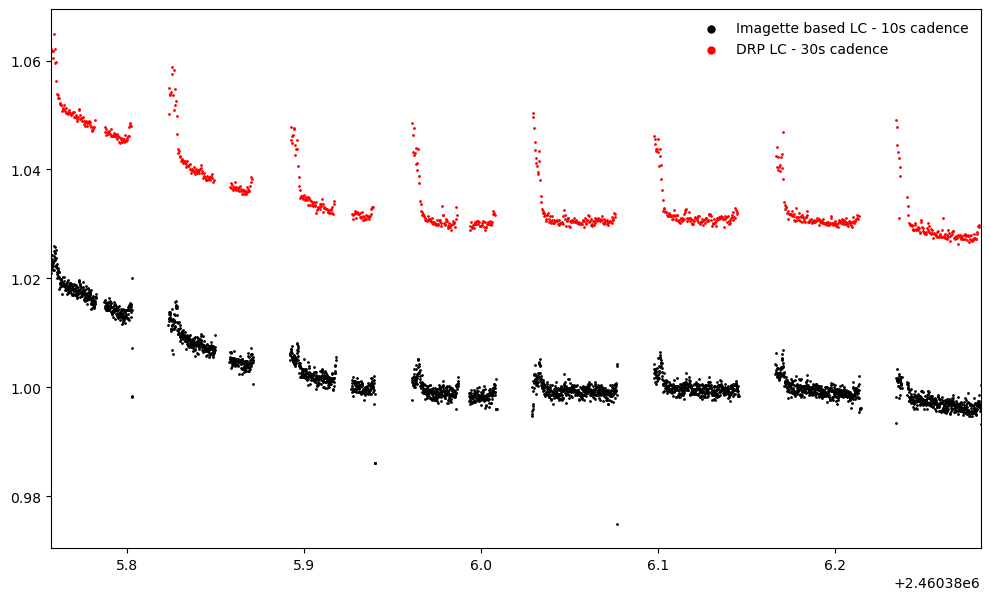

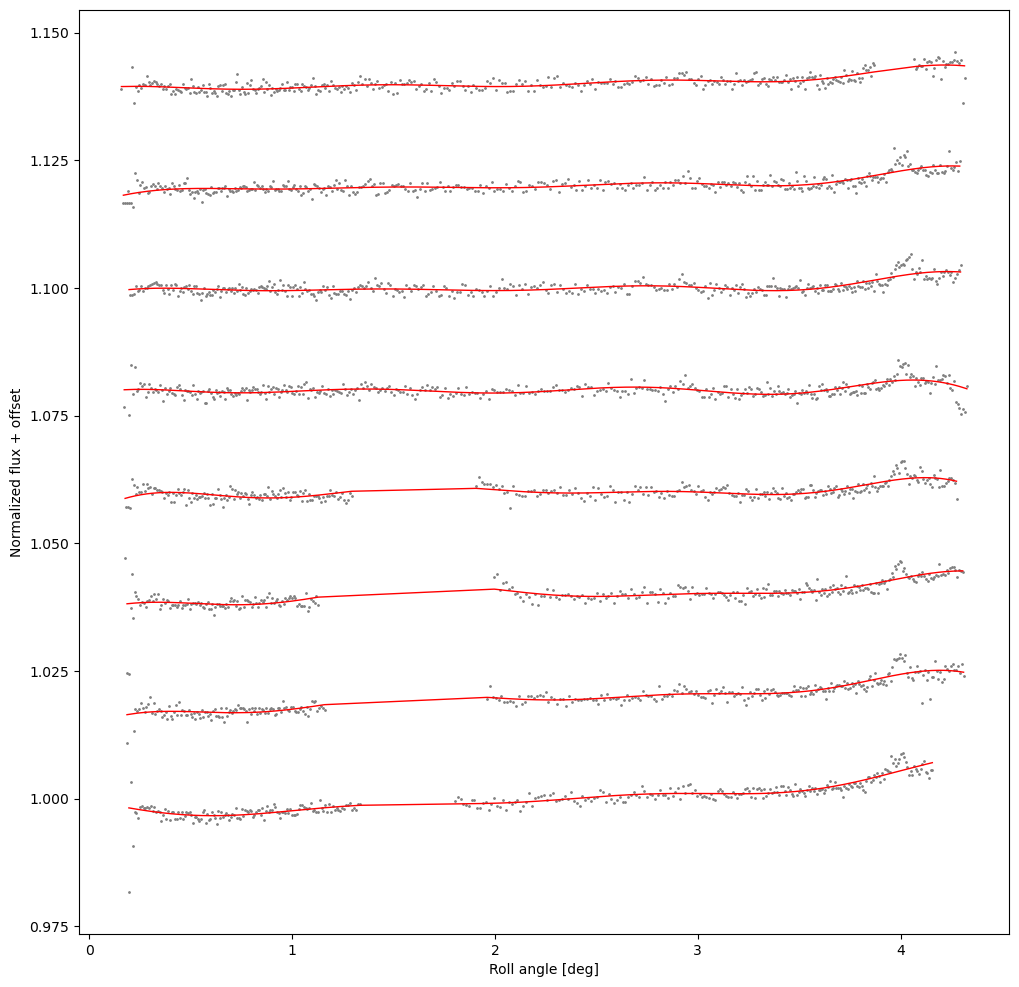

In [169]:
# SET UP THE DATA STRUCTURE ---------------------------------------------------

# get a timestamp YYYYMMDDHHMMSS
timestamp = time.strftime("%Y%m%d%H")

# open the fits file
file ="20240319122713"

# make a  directory in plots for the results
os.makedirs(f"../plots/{file}", exist_ok=True)


# COMPARE DRP TO IMAGETTE BASED LIGHTCURVE --------------------------------------   

# # open the DRP LC
DRP = glob.glob(f'../data/hip67522/CHEOPS-products-{file}/*_SCI_COR_Lightcurve-DEFAULT_V0300.fits')
print(f"DRP file found for {file}:\n {DRP}\n")
cor = fits.open(DRP[0])

# get the correct columns
t, f, ferr, s, roll = cor[1].data['BJD_TIME'], cor[1].data['FLUX'], cor[1].data['FLUXERR'], cor[1].data['STATUS'], cor[1].data['ROLL_ANGLE']

# only use s==0
mask = (s == 0)

tdrp, fdrp, ferrdrp, rolldrp = t[mask], f[mask], ferr[mask], roll[mask]

# GET THE IMAGE DATA -----------------------------------------------------------

hdulist = fits.open(f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/hip67522_CHEOPS-products-{file}_im.fits')

# get the image data
image_data = hdulist[1].data

t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

# make sure the data is in fact 10s cadence
assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

# big endian to little endian
t = t.byteswap().newbyteorder()
f = f.byteswap().newbyteorder()
ferr = ferr.byteswap().newbyteorder()
roll = roll.byteswap().newbyteorder()

# PLOT THE DRP VS IMAGETTE DATA ---------------------------------------------------

plt.figure(figsize=(12, 7))

plt.scatter(t, f/np.median(f), s=1, label="Imagette based LC - 10s cadence", c="k")
plt.scatter(tdrp, fdrp/np.median(fdrp) + 5 * np.std(f/np.median(f)), s=1, label="DRP LC - 30s cadence", c="r")

# layout
# make symbols in legend larger
plt.legend(markerscale=5, frameon=False)

t0 = min(t.min(), tdrp.min())
tf = max(t.max(), tdrp.max())
plt.xlim(t0,tf)

# save the plot
plt.savefig(f"../plots/{file}/{timestamp}_DRP_vs_Imagette.png", dpi=300)


# FIT THE ROLL ANGLE SYSTEMATICS ---------------------------------------------------


# split by roll angle diff 
roll_diff = np.diff(roll)

# index the data by where the roll angle change is positive
index = np.where(roll_diff > 0)[0]

# add an incremental index to each phase between the indices
phase = np.zeros(len(roll))
phase[:index[0]] = 0
for i in range(len(index) - 1):
    phase[index[i]:index[i+1]] = i+1
phase[index[-1]:] = len(index) 

# make a Dataframe for easy indexing
df = pd.DataFrame({"BJD": t, "FLUX": f, "FLUXERR": ferr, "ROLL": roll, "PHASE": phase})


# open a diagnostic plot
plt.figure(figsize=(12, 12))

# init a model array
model = np.array([])

# go roll by roll
for ro, g in df.groupby("PHASE"):

    # sort by roll angle
    g = g.sort_values("ROLL")

    # convert roll to radians
    rr = np.radians(g["ROLL"])

    # normalize the flux and fluxerr
    ff = g["FLUX"] / np.median(g["FLUX"])
    fferr = g["FLUXERR"] / np.median(g["FLUX"])

    # plot the data with an offset
    plt.scatter(rr, ff + ro/50. , s=1, c="grey")

    # clip 5 sigma outliers
    mask = np.abs(ff - np.median(ff)) < 5 * np.std(ff)

    # use the masked data for the fit
    rrm, ffm, fferrm = rr[mask], ff[mask], fferr[mask]

    # fit roll angle systematics to roll, flux, flux_err 
    # optimize a_s and b_s
    res = minimize(fit_roll_angle_sys, x0=np.ones(10)/10., args=(rrm, ffm, fferrm))

    # calculate the model light curve
    a_s = res.x[:5]
    b_s = res.x[5:]
    m = roll_angle_sys(rr, a_s, b_s)

    # plot the model light curve
    plt.plot(rr, m + ro/50., c='r', lw=1)

    # append model
    g["MODEL"] = m * np.median(g["FLUX"])

    # sort abck by BJD
    g = g.sort_values("BJD")
    model = np.append(model, g["MODEL"])


# add model to the Dataframe
df["MODEL"] = model

# layout the diagnostic plot
plt.xlabel("Roll angle [deg]")
plt.ylabel("Normalized flux + offset")
plt.savefig(f"../plots/{file}/{timestamp}_roll_angle_systematics.png", dpi=300)

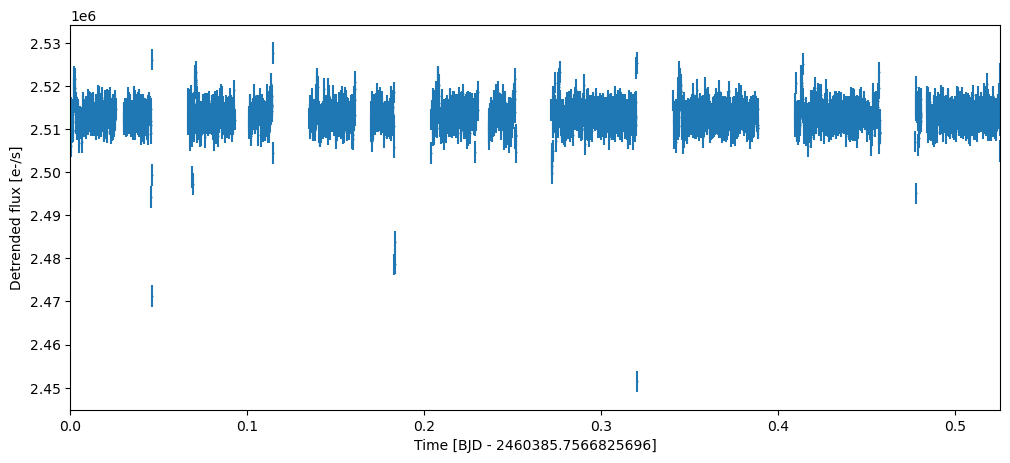

In [172]:
# DEFINE THE DETRENDED FLUX --------------------------------------------------

df["DETRENDED"] = df["FLUX"] - df["MODEL"] + np.median(df["FLUX"])

# DEFINE THE DETRENDED ERROR --------------------------------------------------

# mask outliers
mask = np.abs(df["DETRENDED"] - np.median(df["DETRENDED"])) < 5 * np.std(df["DETRENDED"])

df["DETRENDED_ERR"] = df.loc[mask, "DETRENDED"].std()

# MAKE DIAGNOSTIC FIGURE OF THE RESIDUALS ---------------------------------------------------

plt.figure(figsize=(12, 5))

# plot the detrended flux
plt.errorbar(df["BJD"] - df["BJD"].iloc[0], df["DETRENDED"], yerr=df["DETRENDED_ERR"], fmt=".", markersize=1)

# layout
plt.xlabel(f"Time [BJD - {df['BJD'].iloc[0]}]")
plt.ylabel("Detrended flux [e-/s]")

plt.xlim(0, df["BJD"].iloc[-1] - df["BJD"].iloc[0])

# save the plot
plt.savefig(f"../plots/{file}/{timestamp}_detrended_flux.png", dpi=300)

In [173]:
# FIND FLARES --------------------------------------------

# define flare light curve
flc = FlareLightCurve(time=df["BJD"], flux=df["DETRENDED"], flux_err=df["DETRENDED_ERR"])

# define detrended flux
flc.detrended_flux = df["DETRENDED"]
flc.detrended_flux_err = df["DETRENDED_ERR"]

# find flares
flares = flc.find_flares().flares

# delete unnecessary columns
del flares["cstart"]
del flares["cstop"]

# add file number
flares["file"] = file

# add total number of valid data points to a metadata file, together with file date
with open("../results/flare_metadata.txt", "a") as f:
    f.write(f"{timestamp},{file},{len(df)},{len(flares)}\n")

# write out flare to file
flares.to_csv("../results/flares.csv", index=False)

Found 4 candidate(s) in the (0,3048) gap.
/home/ilin/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


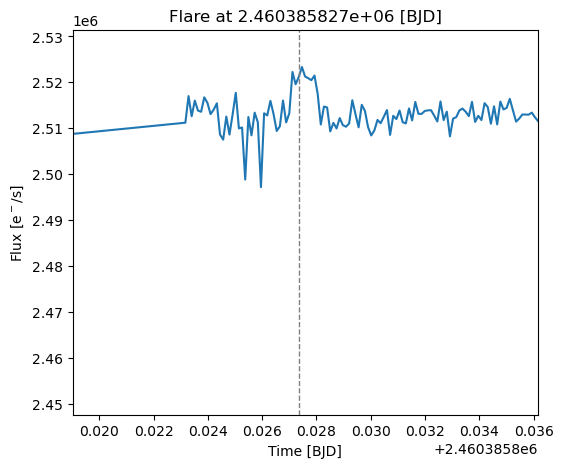

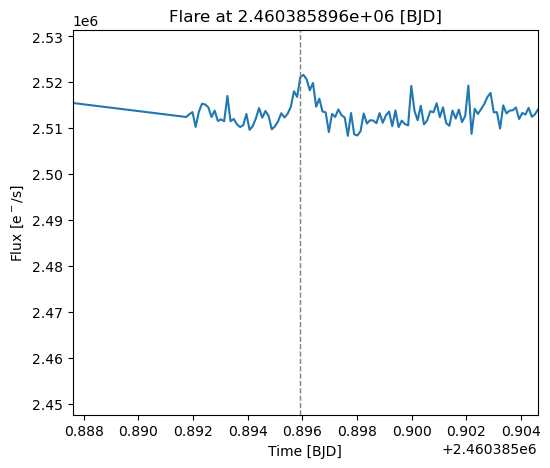

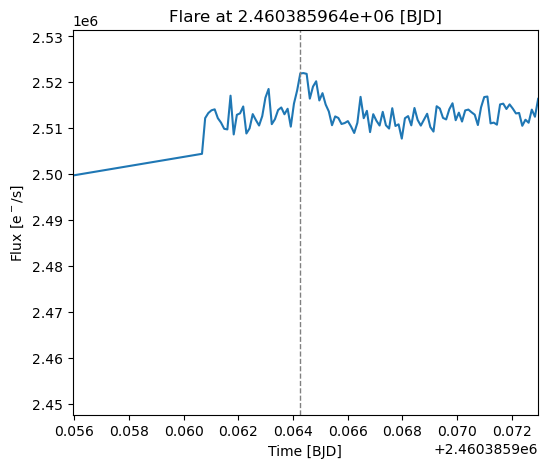

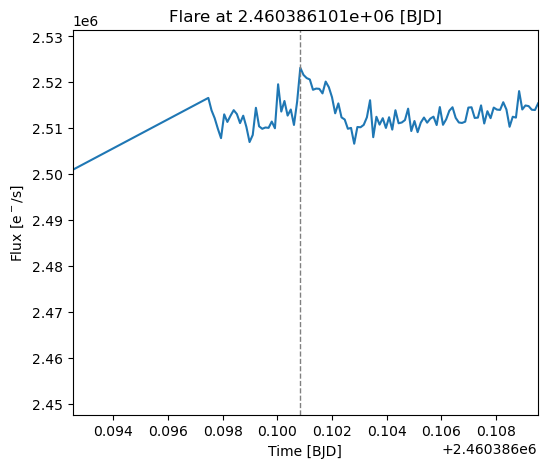

In [175]:
# MAKE DIAGNOSTIC PLOT OF EACH FLARE --------------------------------------------

# make a directory for the flare plots inside the file directory
os.makedirs(f"../plots/{file}/flares", exist_ok=True)

# plot each flare in its own figure
for r, fl in flares.iterrows():
    plt.figure(figsize=(6, 5))
    plt.plot(flc.time.value, flc.detrended_flux, label="masked")
    plt.axvline(fl.tstart, c='grey', lw=1, linestyle='--')
    plt.xlim(fl.tstart - 0.2/24, fl.tstop + 0.2/24)
    plt.xlabel("Time [BJD]")
    plt.ylabel(r"Flux [e$^-$/s]")   
    plt.title(f"Flare at {fl.tstart:.9e} [BJD]")
    plt.savefig(f"../plots/{file}/flares/{timestamp}_flare_{fl.tstart:.9e}.png", dpi=300)

In [135]:
# find all files in data that contain CHEOPS-products and _im.fits in the Outdata/ directory
import glob

files = glob.glob("../data/hip67522/CHEOPS-products-*/Outdata/*/*CHEOPS-products-*_im.fits")


# cp the files to /home/ilin/Documents/2024_03_HIP67522_Paper/HIP67522-Paper/src/data
import os
for file in files:
    os.system(f"cp {file} /home/ilin/Documents/2024_03_HIP67522_Paper/HIP67522-Paper/src/data/cheops")

files

['../data/hip67522/CHEOPS-products-20240319122713/Outdata/00000/hip67522_CHEOPS-products-20240319122713_im.fits',
 '../data/hip67522/CHEOPS-products-20240312075007/Outdata/00002/hip67522_CHEOPS-products-20240312075007_im.fits',
 '../data/hip67522/CHEOPS-products-20240322074703/Outdata/00002/hip67522_CHEOPS-products-20240322074703_im.fits']

In [68]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np


from altaipony.flarelc import FlareLightCurve
from altaipony.customdetrend import custom_detrending
from altaipony.utils import sigma_clip


# open the fits file
hdulist = fits.open(files[0])

# get the image data
image_data = hdulist[1].data

t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

obsid = hdulist[1].header["OBSID"]
print(obsid)


# big endian to little endian
t = t.byteswap().newbyteorder()
f = f.byteswap().newbyteorder()
ferr = ferr.byteswap().newbyteorder()
roll = roll.byteswap().newbyteorder()

# mask def for outlier clipped
max_sigma = 6

# mask def for identifying chunks of data
maxgap = 2 / 60 / 24 # 2 minutes
minspan = 3 / 60 / 24 # 3 minutes

# savgol filter window lengths in hours
savgol1 = 0.5 # 30 min
savgol2 = 0.25 # 15 min

# make sure the data is in fact 10s cadence
assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

2367052


/tmp/ipykernel_194510/2272952187.py:12: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240322074703/Outdata/00002/hip67522_CHEOPS-products-20240322074703_im.fits'>
  hdulist = fits.open(files[0])


In [69]:
# cast the data as a FlareLightCurve
lc = FlareLightCurve(time=t, flux=f, flux_err=ferr)

# identify gaps in the data
lc = lc.find_gaps(maxgap=maxgap, minspan=minspan)

print(lc.gaps)

# detrend the light curve
lcd = lc.detrend("custom", func=custom_detrending, **{"savgol1": savgol1, "savgol2": savgol2})

# clip outliers because if there are big flares, we'll pick them out by eye
mask = sigma_clip(lcd.detrended_flux, max_sigma=max_sigma)
lcd2 = lcd
# lcd2[mask] = np.nan


# find flares
flares = lcd2.find_flares().flares

flares

[(0, 222), (222, 360), (360, 588), (588, 705), (705, 930), (930, 1047), (1047, 1275), (1275, 1410), (1410, 1827), (1827, 2241), (2241, 2658), (2658, 2688), (2688, 3048)]


Found 11 candidate(s) in the (0,3048) gap.
/home/ilin/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,17,21,NaN,NaN,2.460386e+06,2.460386e+06,0.122408,0.014255,0.003616,0.000464,3048.0
1,303,355,NaN,NaN,2.460386e+06,2.460386e+06,5.878564,0.049040,0.013198,0.006034,3048.0
2,360,603,NaN,NaN,2.460386e+06,2.460386e+06,19.191992,0.124052,0.013665,0.036203,3048.0
3,694,698,NaN,NaN,2.460386e+06,2.460386e+06,0.141771,0.013060,0.005101,0.000464,3048.0
4,705,719,NaN,NaN,2.460386e+06,2.460386e+06,0.559121,0.028012,0.005303,0.001624,3048.0
5,735,750,NaN,NaN,2.460386e+06,2.460386e+06,0.579838,0.026225,0.005887,0.001741,3048.0
6,1076,1086,NaN,NaN,2.460386e+06,2.460386e+06,0.347455,0.021591,0.004813,0.001160,3048.0
7,1446,1451,NaN,NaN,2.460386e+06,2.460386e+06,0.197793,0.015799,0.004689,0.000580,3048.0
8,1834,1837,NaN,NaN,2.460386e+06,2.460386e+06,0.079998,0.013365,0.002934,0.000348,3048.0
9,1849,1867,NaN,NaN,2.460386e+06,2.460386e+06,0.692398,0.028961,0.006115,0.002089,3048.0


/home/ilin/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


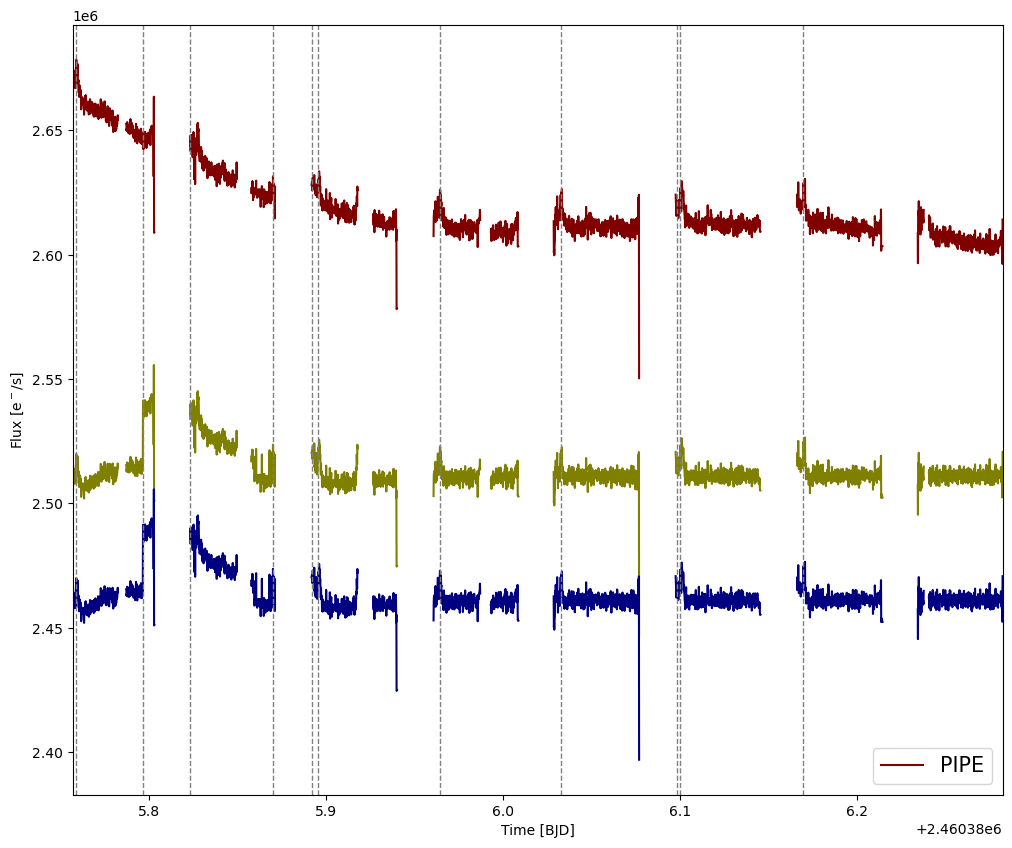

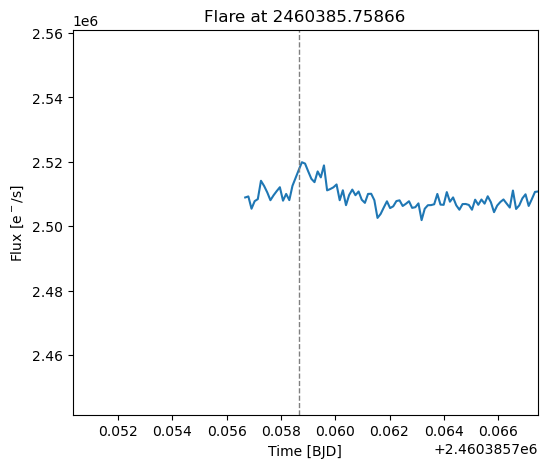

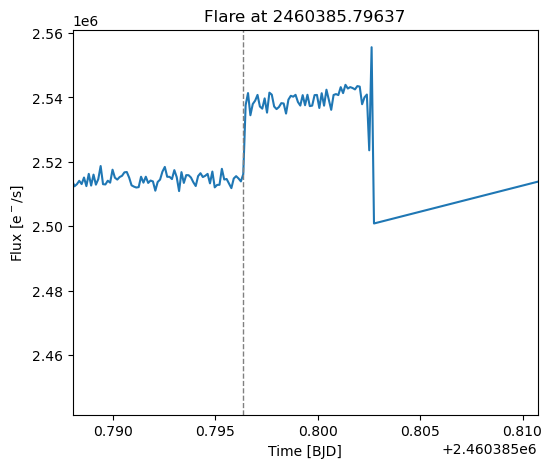

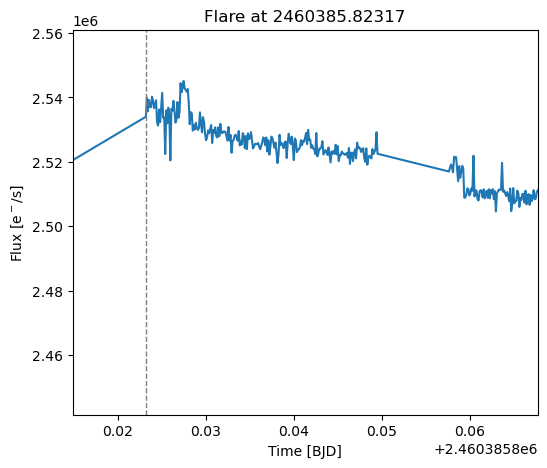

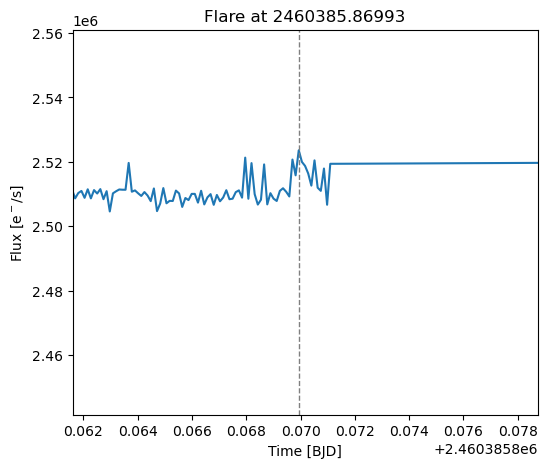

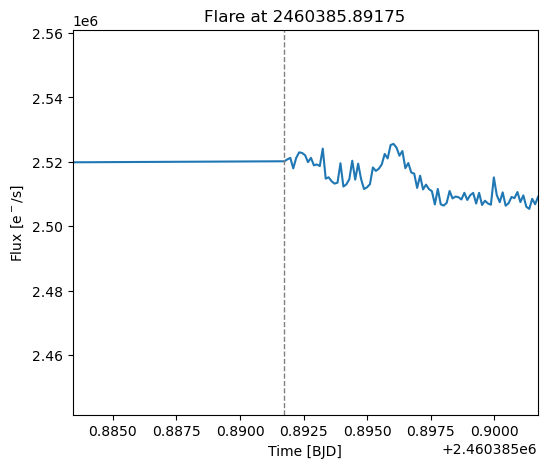

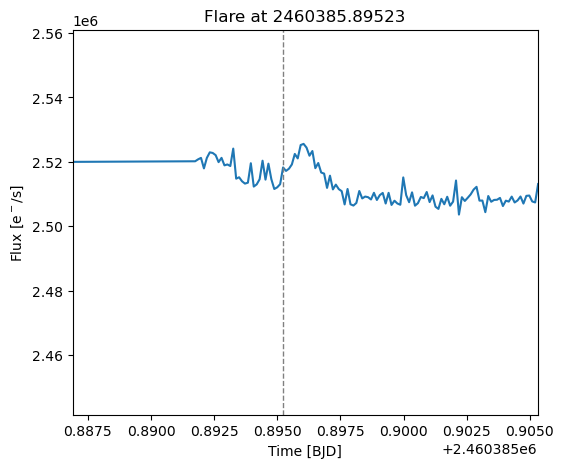

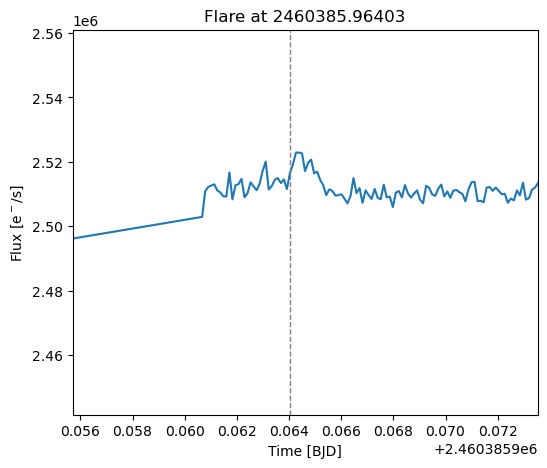

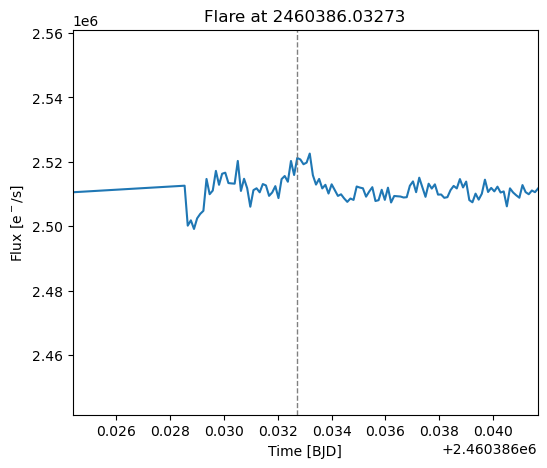

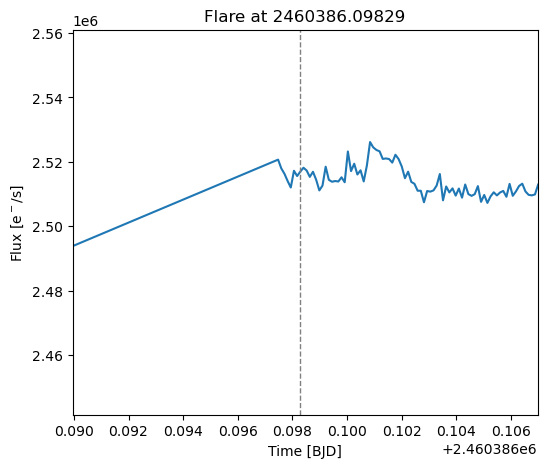

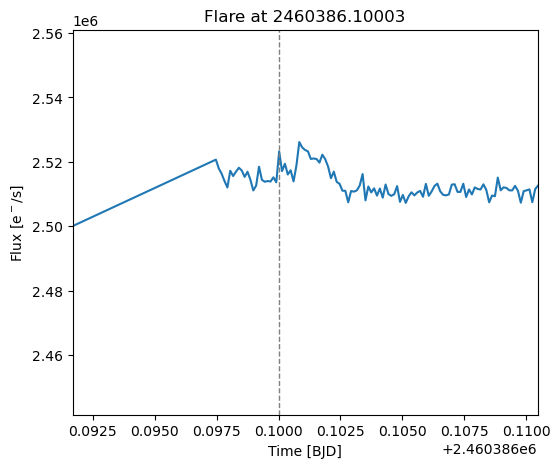

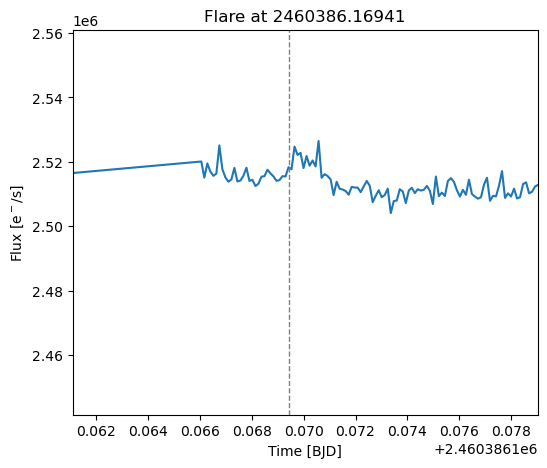

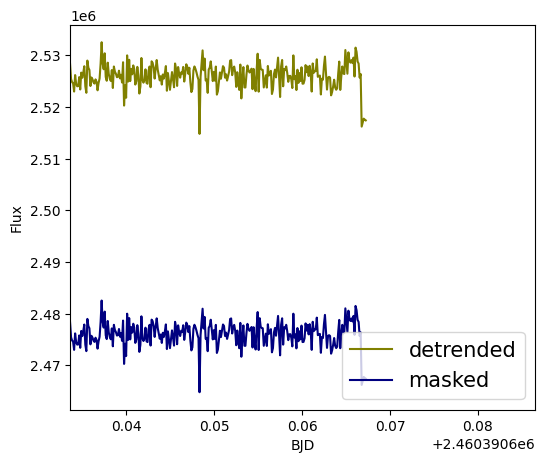

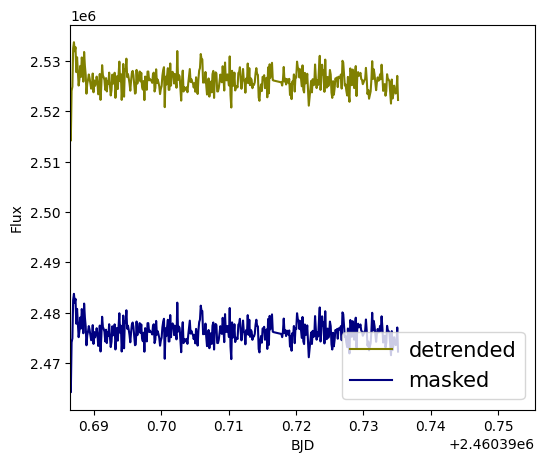

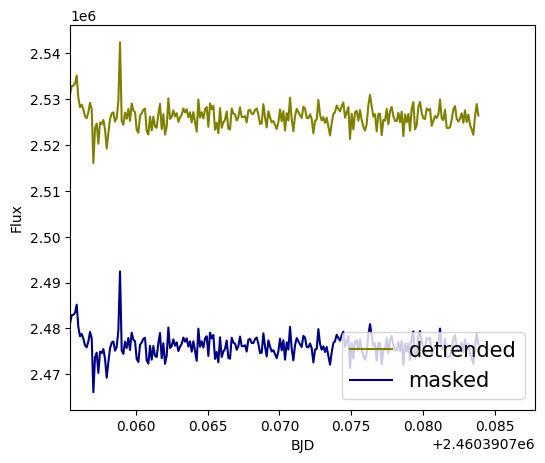

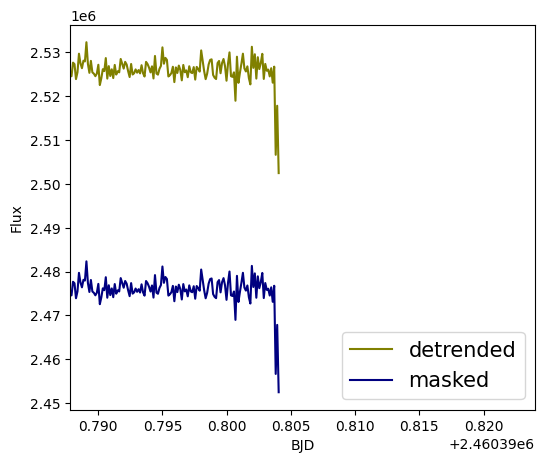

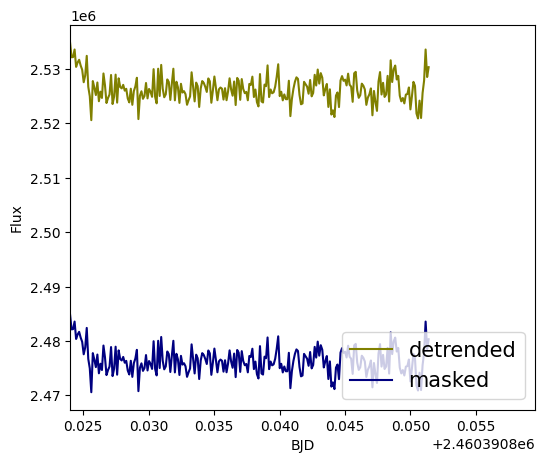

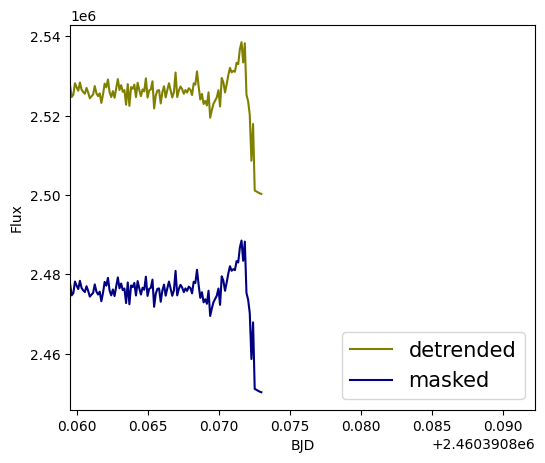

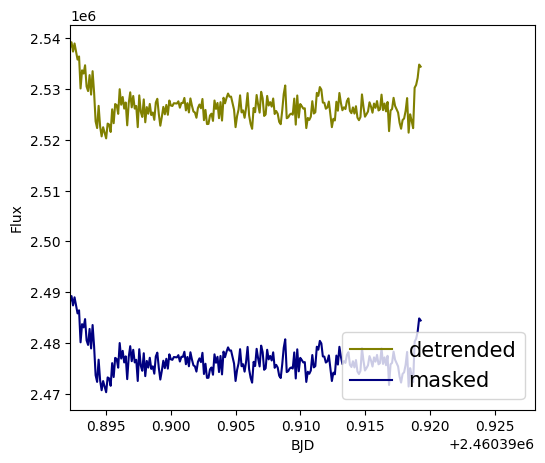

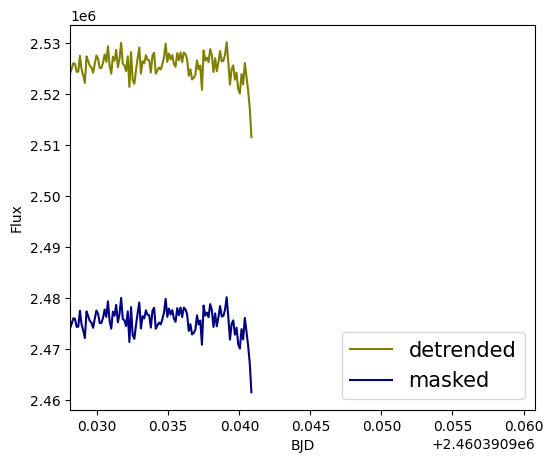

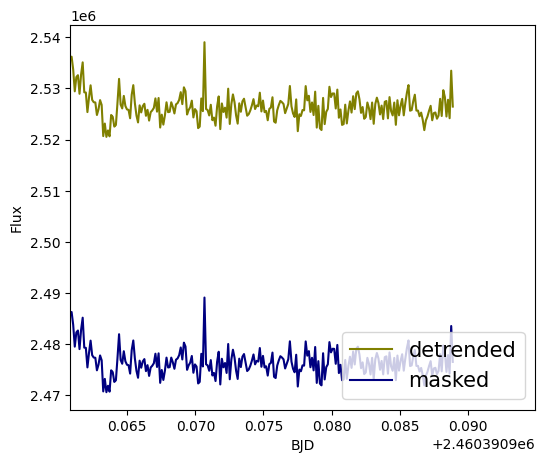

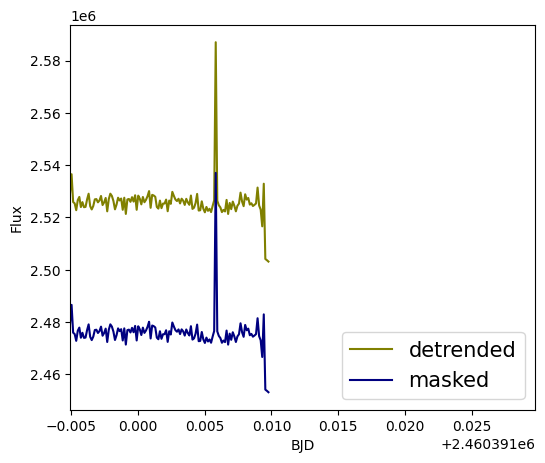

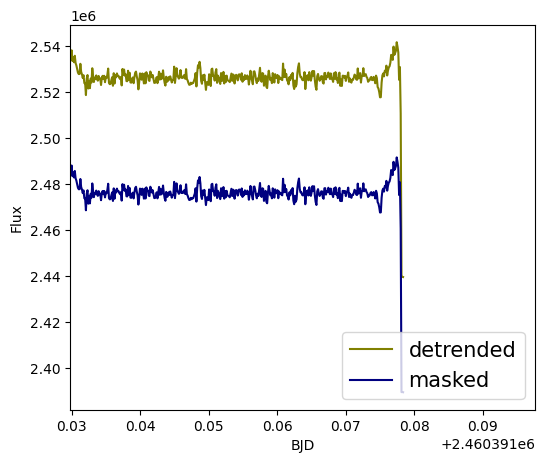

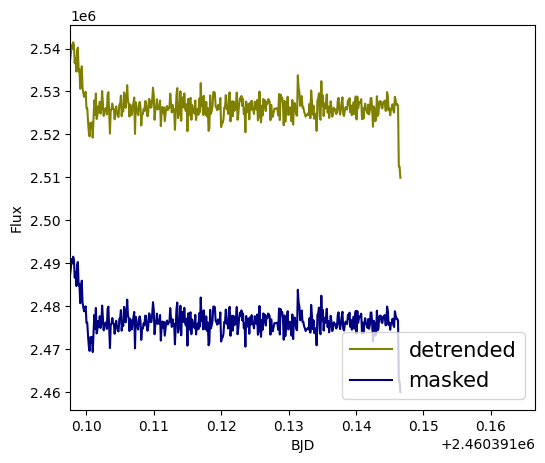

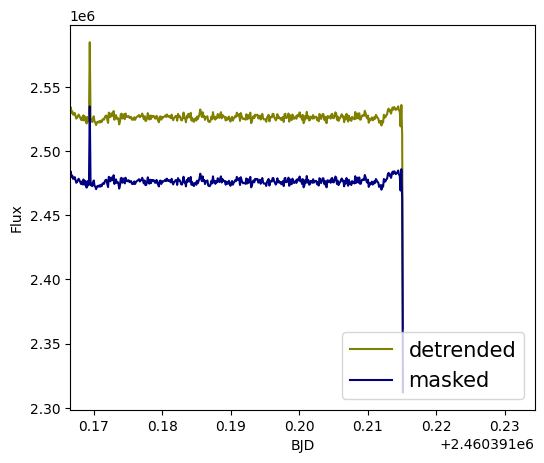

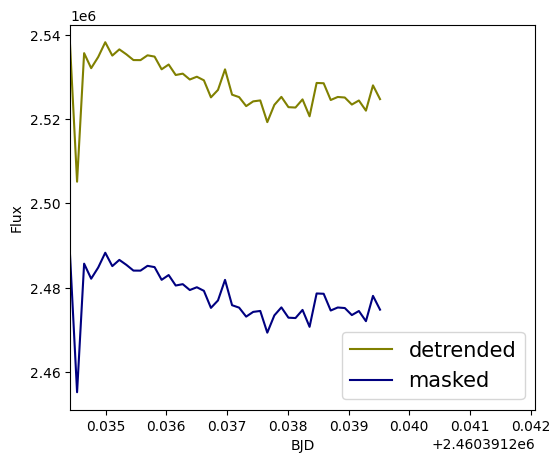

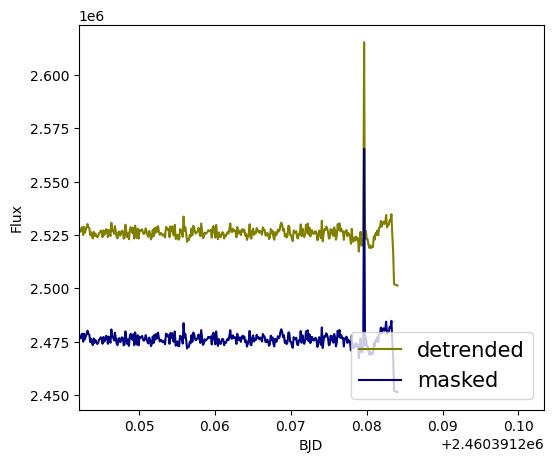

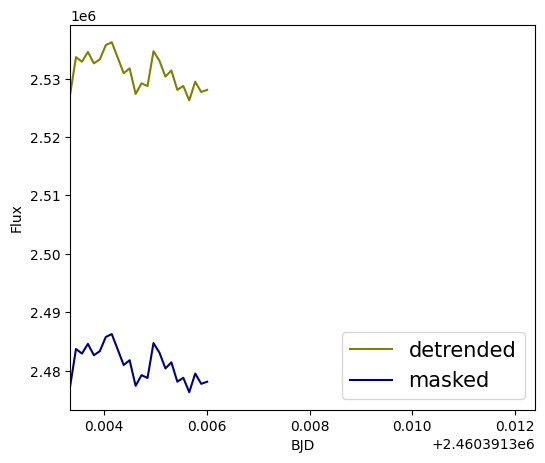

IndexError: index 3975 is out of bounds for axis 0 with size 3975

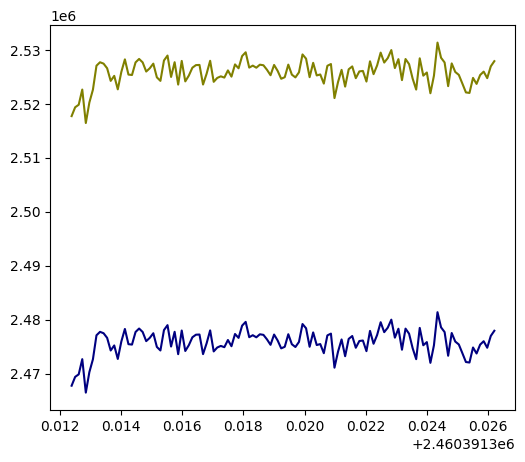

In [24]:
# also plot lcd2 and lc in each gap in a separate figure
for g in lc.gaps:
    plt.figure(figsize=(6, 5))
    # plt.plot(lc.time.value[g[0]:g[1]], lc.flux[g[0]:g[1]]+1e5, c='maroon', label="PIPE")
    plt.plot(lcd.time.value[g[0]:g[1]], lcd.detrended_flux[g[0]:g[1]], c='olive', label="detrended")
    plt.plot(lcd2.time.value[g[0]:g[1]], lcd2.detrended_flux[g[0]:g[1]]-5e4, c='navy', label="masked")
    plt.xlim(lcd2.time.value[g[0]], lcd2.time.value[g[1]])
    plt.xlabel("BJD")
    plt.ylabel("Flux")
    plt.legend(fontsize=15, loc=4)
    plt.show()

In [72]:
# flag all flares that are closer than 10 data points to a gap using lcd2.gaps
gaps = lcd2.find_gaps(maxgap=2 / 60 / 24, minspan=3 / 60 / 24).gaps

distance = 20
flares["close_to_gap"] = False
for r, fl in flares.iterrows():
    for g in gaps:
        if (fl.istart > g[0]) and (fl.istop < g[1]):
            if (fl.istart < (g[0] + distance)) or (fl.istop > (g[1] - distance)):
                flares.loc[r, "close_to_gap"] = True

flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,close_to_gap
0,52,59,NaN,NaN,2.460381e+06,2.460381e+06,0.235028,0.017837,0.003886,0.000812,3671.0,True
1,320,323,NaN,NaN,2.460381e+06,2.460381e+06,0.095636,0.011357,0.003679,0.000348,3671.0,True
2,626,631,NaN,NaN,2.460381e+06,2.460381e+06,0.111786,0.014754,0.002595,0.000580,3671.0,True
3,991,1003,NaN,NaN,2.460381e+06,2.460381e+06,-11.186788,0.765642,0.004826,0.028312,3671.0,False
4,1717,1720,NaN,NaN,2.460381e+06,2.460381e+06,0.086005,0.011740,0.003036,0.000348,3671.0,False
5,3096,3100,NaN,NaN,2.460381e+06,2.460381e+06,0.102669,0.013147,0.003204,0.000464,3671.0,True
6,3121,3125,NaN,NaN,2.460382e+06,2.460382e+06,0.138815,0.013615,0.004003,0.000464,3671.0,True
7,3458,3461,NaN,NaN,2.460382e+06,2.460382e+06,0.093615,0.010624,0.004873,0.000348,3671.0,True


In [35]:
# calculate the total number of datapoint in lcd2
total_points = len(lcd2)
total_observation_time_h = total_points * np.diff(t).min() * 24
total_observation_time_h

11.068749893456697

In [39]:
obsid

2372811